# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import chi2, SelectKBest
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.datasets import make_classification

np.random.seed(1234)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('fraud_financial.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [6]:
temp_columns = ['type','isFraud','isFlaggedFraud']
print("------------------------->> Values for each categorical feature & their value counts <<------------------------- ")
for i in temp_columns:
    print(df[i].value_counts())
    print("----------------------------")

------------------------->> Values for each categorical feature & their value counts <<------------------------- 
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
----------------------------
0    6354407
1       8213
Name: isFraud, dtype: int64
----------------------------
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64
----------------------------


In [7]:
df.isnull().sum().sum()

0

In [8]:
df.duplicated().sum()

0

# Studying insights obtained from the data :

In [9]:
count=0
for i, j in zip(df['isFraud'],df['isFlaggedFraud']):
    if(i==1 and j==1):
        count+=1
print(count)

# this indicates that is isFlaggedFraud is a very strong indicator of fraud transactions

16


In [12]:
df["isFraud"].value_counts(normalize=True)
# 99 % of the data is not fraud-transactions
# this indicates that the data is highly imbalanced

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [13]:
type_of_fraud_transaction = []
for i, j in zip(df['type'],df['isFraud']):
    if(j==1):
        type_of_fraud_transaction.append(i)
type_of_fraud_transaction = set(type_of_fraud_transaction)

print(type_of_fraud_transaction) 

# this indicates that only cashout and transfer transactions can be fraud transactions

{'CASH_OUT', 'TRANSFER'}


In [14]:
fraud_acc = []
for i, j in zip(df['nameDest'],df['isFraud']):
    if(j==1):
        fraud_acc.append(i)
fraud_acc = set(fraud_acc)
print(len(fraud_acc))

# This indicates that fraudsters have commited a fraud more than once using the same account.
# as total fraud transactions = 8213 & total fraud accounts = 8169

8169


In [15]:
count = 0
for i, j in zip(df['nameDest'],df['isFraud']):
    if((i in fraud_acc) and j==0):
        count+=1
print(count)
# Fraudulent accounts have also commited non fraud transactions : 
# Hence we can't identify a fraud transaction even if the recipient account is included in the fraud_acc list

57435


# Outlier detection

<Axes: >

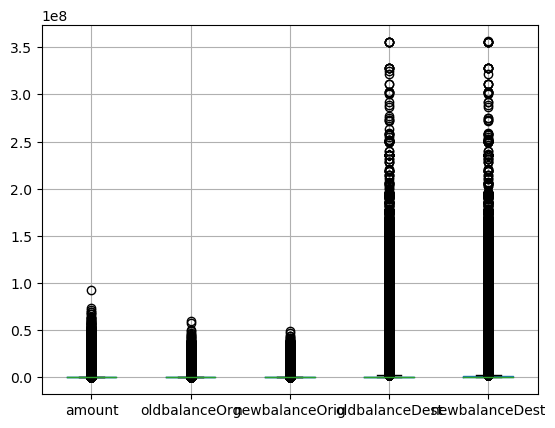

In [17]:
df.boxplot(return_type='axes',column = ['amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [18]:
# Method 1 of detecting outliers in a passed column of a dataframe
def outlier_count_1(data):
    outliers = []
    count = 0
    threshold = 3  #values farer from 3rd S.D. will be considered outliers
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i-mean)/std
        if np.abs(z_score)>threshold:
            outliers.append(i)
            count+=1
    print(count)

# Method 2
# only values below lower threshold and above upper threshold will be considered outliers
def outlier_count_2(data):
    lower_outliers = []
    upper_outliers = []
    count = 0
    q1,q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lower_fence = q1-iqr*1.5
    upper_fence = q3+iqr*1.5
    
    for i in data:
        if(i<lower_fence):
            lower_outliers.append(i)
            count+=1
        elif(i>upper_fence):
            upper_outliers.append(i)
            count+=1
    print(count)

In [19]:
# create a function to get all outliers for int/float columns
outlier_count_1(df['amount'])

44945


In [20]:
outlier_count_2(df['amount'])

338078


# Checking for multi-collinearity

In [21]:
X_variables = df[['step','amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,step,1.188500
1,amount,4.013501
2,oldbalanceOrg,465.124566
3,newbalanceOrig,466.906067
4,oldbalanceDest,71.790542
5,newbalanceDest,83.263477
6,isFlaggedFraud,1.000569


<Axes: >

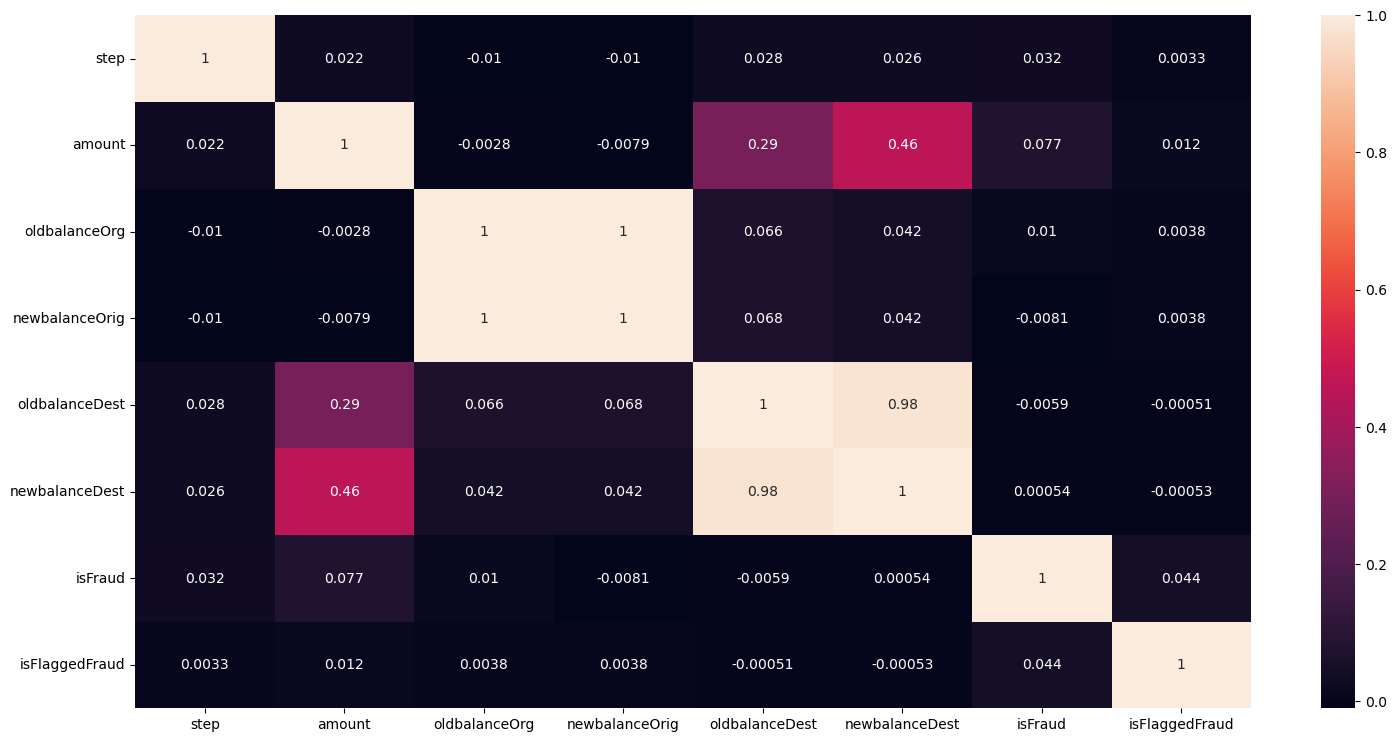

In [24]:
plt.figure(figsize=(18,9))
sns.heatmap(df.corr(),annot=True)

# Identifying potential best numerical features

In [25]:
dummy_data = df.copy()
# dropping categorical features in dummmy data
dummy_data = dummy_data.drop(['nameOrig', 'nameDest','type'], axis=1)

X_dummy = dummy_data.drop("isFraud",axis=1)
y_dummy = dummy_data["isFraud"]
# selecting 6 best out of all numerical features
fs = SelectKBest(score_func=f_classif, k=6)
# apply feature selection
X_selected = fs.fit_transform(X_dummy, y_dummy)

cols = list(X_dummy.columns)
cols_selected = fs.get_feature_names_out(input_features=cols)
print("6 Best features")
print(cols_selected)


fs = SelectKBest(score_func=f_classif, k=3)
# apply feature selection
X_selected = fs.fit_transform(X_dummy, y_dummy)

cols = list(X_dummy.columns)
cols_selected = fs.get_feature_names_out(input_features=cols)
print("Top 3 Best features")
print(cols_selected)

6 Best features
['step' 'amount' 'oldbalanceOrg' 'newbalanceOrig' 'oldbalanceDest'
 'isFlaggedFraud']
Top 3 Best features
['step' 'amount' 'isFlaggedFraud']


# Data preprocessing

In [26]:
# making a copy of data frame for safeguarding info
df_copy = df.copy()
df_copy.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [27]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [28]:
# Creating a function that returns split data along with best selected columns
def data_preprocessor(data):
    data = data.drop(["nameOrig","nameDest"],axis=1)
    data = pd.get_dummies(data,columns=['type'], drop_first=True)
#     print(data.head())
    X = data.drop("isFraud",axis=1)
    y = data["isFraud"]
    
    oversample = RandomOverSampler(sampling_strategy=0.1)
    X, y = oversample.fit_resample(X, y)
    undersample = RandomUnderSampler(sampling_strategy=0.5)
    X, y = undersample.fit_resample(X, y)
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
    
    scaler = preprocessing.RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    fs = SelectKBest(score_func=f_classif, k=8)
    X_train = fs.fit_transform(X_train, y_train)
    X_test = fs.transform(X_test)
    
    cols = list(X.columns)
    cols_selected = fs.get_feature_names_out(input_features=cols)
    
    return X_train,X_test,y_train,y_test,cols_selected

In [29]:
X_train,X_test,y_train,y_test,cols_selected = data_preprocessor(df)

In [30]:
print("List of selected columns : ",cols_selected)

List of selected columns :  ['step' 'amount' 'oldbalanceOrg' 'newbalanceOrig' 'oldbalanceDest'
 'type_CASH_OUT' 'type_PAYMENT' 'type_TRANSFER']


In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1525056, 8)
(381264, 8)
(1525056,)
(381264,)


In [32]:
print(X_train[:2])

[[-6.78733032e-02  1.47831569e+00  2.80403694e+01  6.01094765e+02
   2.06819324e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.15384615e-01 -1.68885535e-01 -2.44702771e-02  4.94068643e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [33]:
print(y_train[:2])

841276    0
356546    0
Name: isFraud, dtype: int64


# Model Building

In [34]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
log_reg_pred = log_reg.predict(X_test)

Model 2

In [35]:
knn =  KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [36]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [37]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [38]:
dtc =  DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

# Model Evaluation

In [39]:
def show_accuracy(y_true,y_pred):
    print("Accurate Predictions : ",accuracy_score(y_true,y_pred, normalize=False),"/",len(y_test))
    print("Accuracy Score : ",round(accuracy_score(y_true,y_pred),2))
    print("Confusion matrix : ")
    print(confusion_matrix(y_true,y_pred))
    print("Precision Score : ",round(precision_score(y_true, y_pred),2))
    print("Recall Score : ",round(recall_score(y_true, y_pred),2))
    print("F1 Score : ",round(f1_score(y_true, y_pred),2))

In [40]:

count_0 = 0
count_1 = 0
for i in y_test :
    if i==1:
        count_0+=1 
    elif i==0:
        count_1+=1 
print("Total No. of Not Fraud transactions in test data: ",count_0)
print("Total No. of Not Fraud transactions in test data:: ",count_1)
print("Total  transactions in test data:: ",count_0+count_1)

Total No. of Not Fraud transactions in test data:  127314
Total No. of Not Fraud transactions in test data::  253950
Total  transactions in test data::  381264


In [41]:
print("----------------------LogisticRegression()----------------------")
show_accuracy(y_test,log_reg_pred)

----------------------LogisticRegression()----------------------
Accurate Predictions :  360837 / 381264
Accuracy Score :  0.95
Confusion matrix : 
[[246346   7604]
 [ 12823 114491]]
Precision Score :  0.94
Recall Score :  0.9
F1 Score :  0.92


In [42]:
print("----------------------KNeighborsClassifier()----------------------")
show_accuracy(y_test,knn_pred)

----------------------KNeighborsClassifier()----------------------
Accurate Predictions :  380574 / 381264
Accuracy Score :  1.0
Confusion matrix : 
[[253260    690]
 [     0 127314]]
Precision Score :  0.99
Recall Score :  1.0
F1 Score :  1.0


In [43]:
print("----------------------RandomForestClassifier()----------------------")
show_accuracy(y_test,rfc_pred)

----------------------RandomForestClassifier()----------------------
Accurate Predictions :  381165 / 381264
Accuracy Score :  1.0
Confusion matrix : 
[[253851     99]
 [     0 127314]]
Precision Score :  1.0
Recall Score :  1.0
F1 Score :  1.0


In [44]:
print("----------------------XGBClassifier()----------------------")
show_accuracy(y_test,xgb_pred)

----------------------XGBClassifier()----------------------
Accurate Predictions :  380966 / 381264
Accuracy Score :  1.0
Confusion matrix : 
[[253652    298]
 [     0 127314]]
Precision Score :  1.0
Recall Score :  1.0
F1 Score :  1.0


In [45]:
print("----------------------DecisionTreeClassifier()----------------------")
show_accuracy(y_test,dtc_pred)

----------------------DecisionTreeClassifier()----------------------
Accurate Predictions :  381132 / 381264
Accuracy Score :  1.0
Confusion matrix : 
[[253818    132]
 [     0 127314]]
Precision Score :  1.0
Recall Score :  1.0
F1 Score :  1.0
